## Табличное Q-обучение


Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686">


<!-- Раскроем скобки:
$$Q(s,a)\leftarrow (1 - \alpha) \times Q(s,a)+\alpha \times \big (r(s)+\gamma\max_{a'}Q(a',s')\big ).$$ -->

Для обучения будем использовать среду Taxi-v3. Подробнее про данное окружение можно посмотреть в документации: https://gymnasium.farama.org/environments/toy_text/taxi/.

In [3]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

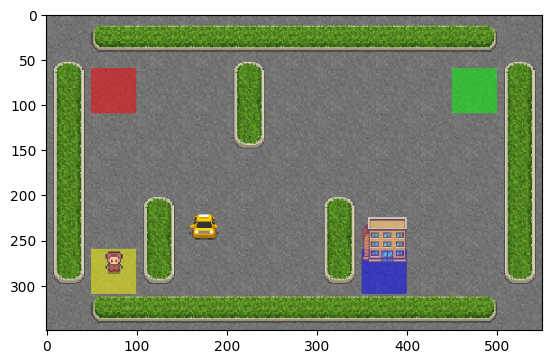

In [5]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [6]:
def show_progress(rewards_batch, log):
    """Функция отображения прогресса обучения."""
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

### Задание 1

Создайте таблицу из нулей, используя информацию из окружения о количестве состояний и действий (1 балл)

In [7]:
def initialize_q_table(n_observation_space, n_action_space):
    Q = np.zeros((n_observation_space, n_action_space))
    return Q

In [8]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

### Задание 2

Напишите код для epsilon-жадного выбора действия (1 балл):

In [9]:
def select_action_eps_greedy(Q, state, epsilon):
    action = np.random.randint(len(Q[state])) if np.random.rand() < epsilon else np.argmax(Q[state])
    return action

Напишите код для формулы Q-обновления (1 балл):

In [10]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    V_ns = np.max(Q[next_s])

    td_error = r + gamma * V_ns - Q[s, a]

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации Q-обучения (2 балла):

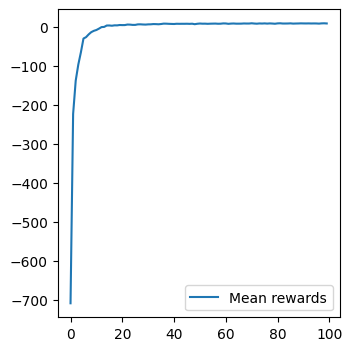

Episode: 10000, Reward: 5, Eps: 0.001246427204280841


In [11]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
n_episodes = 10000

for i_episode in range(1, n_episodes + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        a = select_action_eps_greedy(Q, s, epsilon)

        # выполняем действие в среде
        next_s, r, terminated, truncated, _ = env.step(a)

        update_Q(Q, s, a, r, next_s, alpha, gamma)

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if i_episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(
            f"Episode: {i_episode}, Reward: {episode_reward}"
            f", Eps: {epsilon}"
        )
        epsilon *= epsilon_decay

assert log[-1] >= -10

### Интерпретация результатов (1 балл):
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

In [39]:
params_to_test = [
    {"alpha": 0.1, "epsilon": 0.2, "name": "default"},
    {"alpha": 0.05, "epsilon": 0.2, "name": "low alpha"},
    {"alpha": 0.1, "epsilon": 0.5, "name": "high epsilon"}
]

results = {}
for params in params_to_test:
    Q_test = initialize_q_table(env.observation_space.n, env.action_space.n)
    test_log = []
    test_rewards = []
    eps = params["epsilon"]
    
    for i_episode in range(1, 1001):
        s, _ = env.reset()
        episode_reward = 0
        terminated = False
        
        while not terminated:
            a = select_action_eps_greedy(Q_test, s, eps)
            next_s, r, terminated, truncated, _ = env.step(a)
            update_Q(Q_test, s, a, r, next_s, params["alpha"], gamma)
            s = next_s
            episode_reward += r
        
        test_rewards.append(episode_reward)
        if i_episode % 100 == 0:
            test_log.append(np.mean(test_rewards))
            test_rewards = []
    
    results[params["name"]] = test_log[-1]

for name, score in results.items():
    print(f"{name:15} -> средняя награда: {score:6.2f}")


default         -> средняя награда: -18.13
low alpha       -> средняя награда: -50.86
high epsilon    -> средняя награда: -68.76


## SARSA

Теперь ради интереса попробуем то же самое, но используя метод SARSA.

Для начала, добавим функцию обновления Q-функции (1 балл):

In [18]:
def update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon):
    next_a = select_action_eps_greedy(Q, next_s, epsilon)

    td_error = r + gamma * Q[next_s, next_a] - Q[s, a]

    # обновление Q-функции
    Q[s, a] += alpha * td_error


Допишите код итерации SARSA-обучения (2 балла):

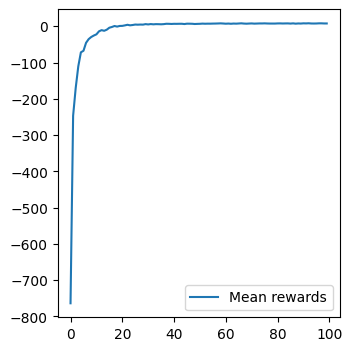

Episode: 10000, Reward: 10, Eps: 0.001246427204280841


In [37]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    terminated = False

    while not terminated:
        a = select_action_eps_greedy(Q, s, epsilon)

        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)

        update_Q_SARSA(Q, s, a, r, next_s, alpha, gamma, epsilon)

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] >= -10

Сравнивая SARSA и Q-learning, что можно сказать об их кривых обучения? (быстрее-медленнее, обучение стабильнее или нет и тп) (1 балл)

In [38]:
Q_qlearn = initialize_q_table(env.observation_space.n, env.action_space.n)
Q_sarsa = initialize_q_table(env.observation_space.n, env.action_space.n)

log_qlearn, log_sarsa = [], []
episodes = 1000

for method, Q, log in [("Q-learning", Q_qlearn, log_qlearn), ("SARSA", Q_sarsa, log_sarsa)]:
    rewards_batch = []
    for i in range(1, episodes + 1):
        s, _ = env.reset()
        episode_reward = 0
        terminated = False
        
        while not terminated:
            a = select_action_eps_greedy(Q, s, 0.2)
            next_s, r, terminated, truncated, _ = env.step(a)
            
            if method == "Q-learning":
                update_Q(Q, s, a, r, next_s, 0.1, 0.9)
            else:
                update_Q_SARSA(Q, s, a, r, next_s, 0.1, 0.9, 0.2)
            
            s = next_s
            episode_reward += r
        
        rewards_batch.append(episode_reward)
        if i % 100 == 0:
            log.append(np.mean(rewards_batch))
            rewards_batch = []

print(f"\nQ-learning:")
print(f"  Финальная награда: {log_qlearn[-1]:.2f}")
print(f"  Стандартное отклонение: {np.std(log_qlearn):.2f}")

print(f"\nSARSA:")
print(f"  Финальная награда: {log_sarsa[-1]:.2f}")
print(f"  Стандартное отклонение: {np.std(log_sarsa):.2f}")

print("Выводы: ")
if log_qlearn[-1] > log_sarsa[-1]:
    print(f"Q-learning показал лучший результат ({log_qlearn[-1]:.2f} > {log_sarsa[-1]:.2f})")
else:
    print(f"SARSA показал лучший результат ({log_sarsa[-1]:.2f} > {log_qlearn[-1]:.2f})")

if np.std(log_qlearn) > np.std(log_sarsa):
    print(f"SARSA более стабилен (std: {np.std(log_sarsa):.2f} < {np.std(log_qlearn):.2f})")
else:
    print(f"Q-learning более стабилен (std: {np.std(log_qlearn):.2f} < {np.std(log_sarsa):.2f})")


Q-learning:
  Финальная награда: -13.06
  Стандартное отклонение: 201.19

SARSA:
  Финальная награда: -23.72
  Стандартное отклонение: 199.44
Выводы: 
Q-learning показал лучший результат (-13.06 > -23.72)
SARSA более стабилен (std: 199.44 < 201.19)
